# MLCMS Exercise 5

In [408]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

DATA_PATH = "./data/"
FIGURE_PATH = "figures/"

plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1
### Reading in Data

In [409]:
A = np.loadtxt(DATA_PATH + "linear_function_data.txt")
B = np.loadtxt(DATA_PATH + "nonlinear_function_data.txt")
X_a = A[:, 0]
F_a = A[:, 1]
X_b = B[:, 0]
F_b = B[:, 1]

Explore data

### Approximating Dataset (A) by a Linear Function
From the sheet we can use that
$$
\begin{aligned}
    (X^T X) \hat{A}^T = X^T F
\end{aligned}
$$
In our case $X^T X$ and $X^T F$ are scalars, hence $\hat{A}^T =: a$ is too.

In [410]:
slope_a = linear_basis_lst_sqr_approx(X_a, F_a)
print("Slope = ", slope_a)

Slope =  0.7500002401387145


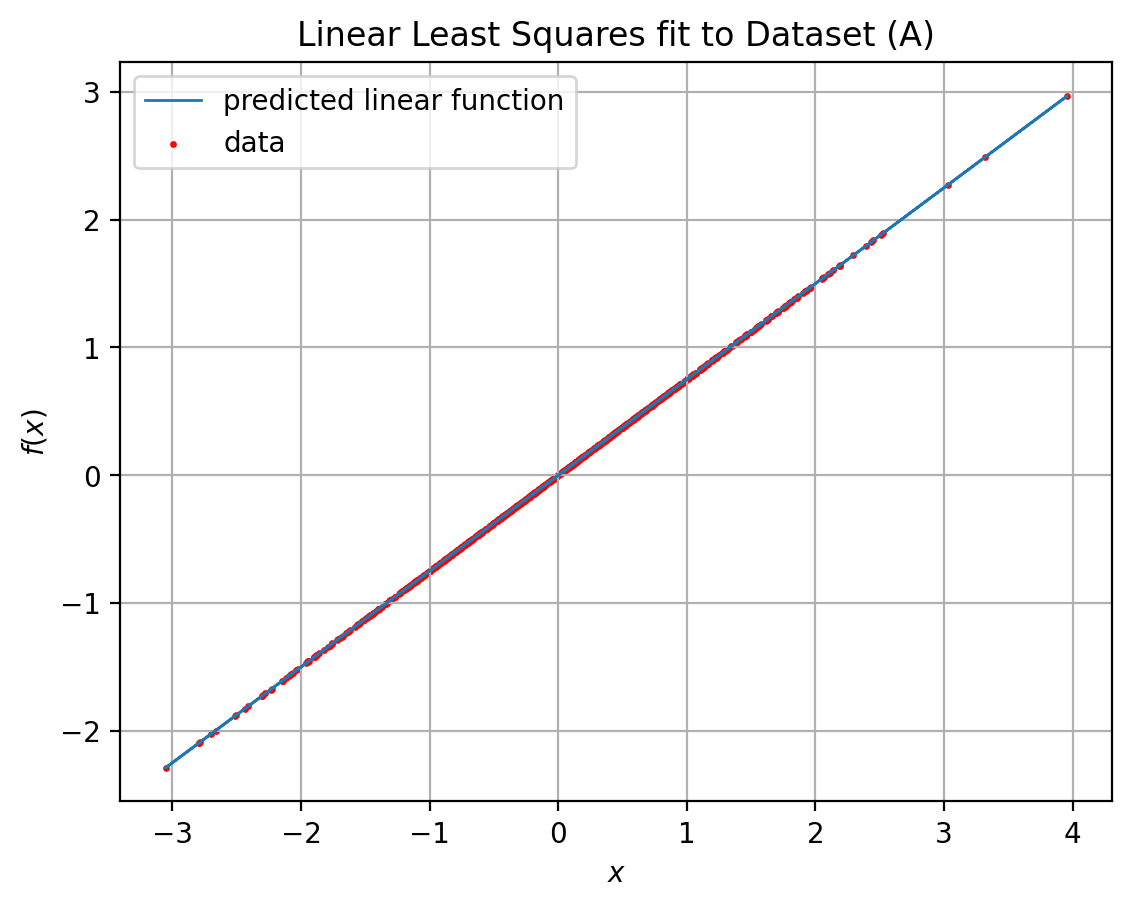

In [411]:
plt.title("Linear Least Squares fit to Dataset (A)")
plt.plot(X_a, slope_a * X_a, linewidth=1, label="predicted linear function")
basic_data_plot_task1(X_a, F_a)
plt.savefig(FIGURE_PATH + "T1_linear_linear.png", bbox_inches='tight')

### Approximating Dataset (B) by a Linear Function

In [412]:
slope_b = linear_basis_lst_sqr_approx(X_b, F_b)
print("Slope = ", slope_b)

Slope =  0.033210360778119924


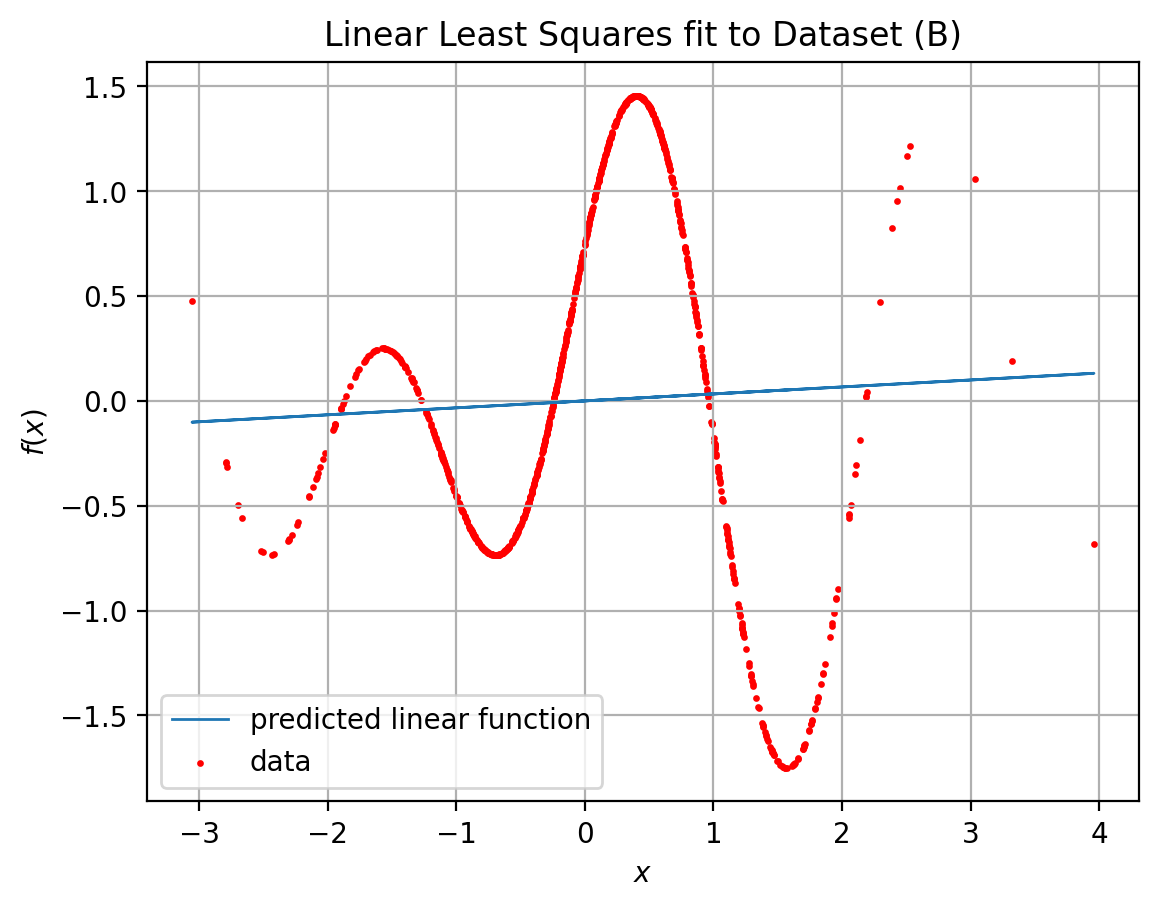

In [413]:
plt.title("Linear Least Squares fit to Dataset (B)")
plt.plot(X_b, slope_b * X_b, linewidth=1, label="predicted linear function")
basic_data_plot_task1(X_b, F_b)
plt.savefig(FIGURE_PATH + "T1_non-linear_linear.png", bbox_inches='tight')

### Approximating Dataset (B) by a Combination of Radial Functions

To aid our intuition and improve our estimation of the required $L$ and $\epsilon$ we observe that the characteristic features of the data have a characteristic length scale of approximately one, since the maxima and minima have a separation of 1 unit of length. We plot two opposite unit Gaussians next to each other:

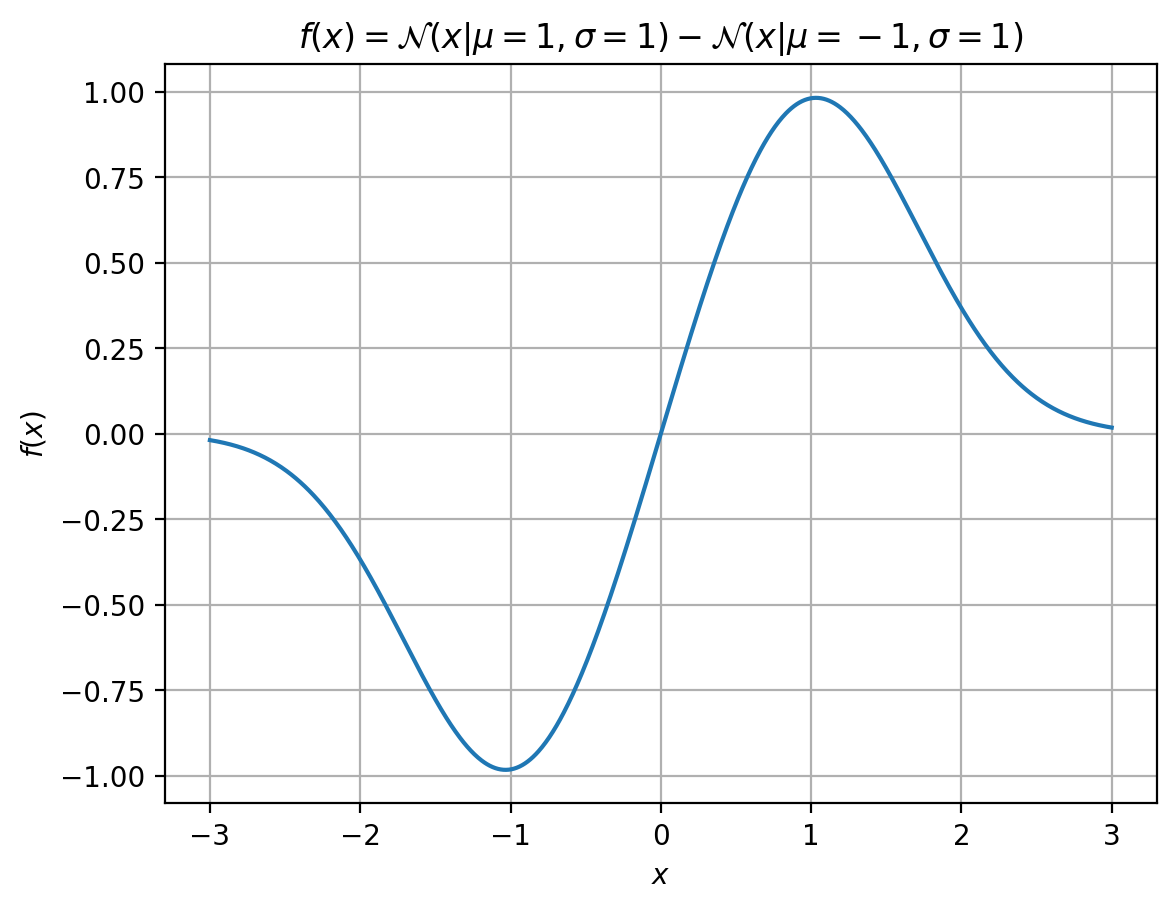

In [414]:
x_gaussian_plot = np.linspace(-3, 3, 1000)
G = np.exp(-(x_gaussian_plot-1)**2) - np.exp(-(x_gaussian_plot+1)**2)
plt.plot(x_gaussian_plot, G)
plt.grid(True)
plt.title(r"$f(x) = \mathcal{N}(x| \mu = 1, \sigma = 1) - \mathcal{N}(x| \mu = -1, \sigma = 1)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.savefig(FIGURE_PATH + "T1_two_gaussians.png", bbox_inches='tight')

For peaks at a distance of one we require the grid spacing of gaussian peaks to be at least on a length scale of $1$. Additionally we note that if the data peaks do not coincide with the grid, we require a higher grid density, hence we double the number of peaks from $8$ at approximately $-3, -2, -1, 0, 1, 2, 3, 4$ to $16$.
Hence we estimate that a good approximation can be achieved by a grid with $L = 16$ at a separation of about $1/2$ with an $\epsilon = 0.5$ as this allows the peaks to be well localized while preserving a reasonable smoothness (no excessive overlap with next nearest neighbor peaks)

In [415]:
EPSILON = 0.5
L = 16
GRID_b = np.linspace(X_b.min(), X_b.max(), L)
R_COND = 1e-2

In [416]:
coefficients = radial_basis_lst_sqr_approx(X_b, F_b, GRID_b, EPSILON, R_COND)
coefficients

Effective Rank:  16


array([ 0.71689816, -0.88082199, -0.22243487,  0.36286874,  0.0221549 ,
       -0.71410586, -0.17718509,  1.02176536,  0.92010521, -0.6333537 ,
       -1.41933319, -0.27600205,  1.10726815,  0.81786417, -0.43317479,
       -0.52892318])

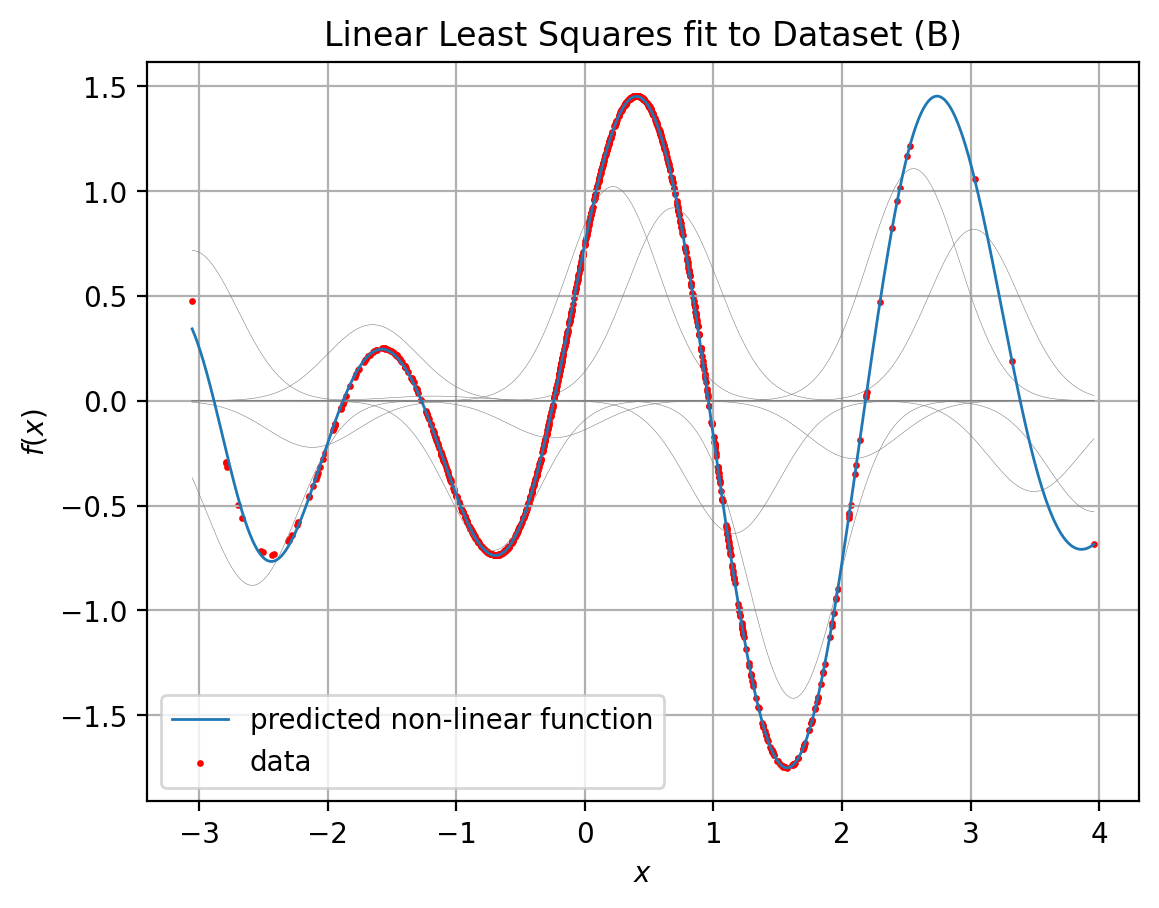

In [417]:
X_plot = np.linspace(X_b.min(), X_b.max(), 1000)
phi_plot = radial_basis(X_plot, GRID_b, epsilon=EPSILON)

# plot contribution from individual basis vectors
for i, c in enumerate(coefficients):
    c_i = np.zeros(L)
    c_i[i] = c
    plt.plot(X_plot, phi_plot @ c_i.T, linewidth=0.2, color="grey")

plt.title("Linear Least Squares fit to Dataset (B)")
plt.plot(X_plot, phi_plot @ coefficients.T, linewidth=1, label="predicted non-linear function")
basic_data_plot_task1(X_b, F_b)
plt.savefig(FIGURE_PATH + "T1_non-linear_radial.png", bbox_inches='tight')

In [420]:
N = 1000
print("Total MSE", np.linalg.norm(F_b - radial_basis(X_b, GRID_b, EPSILON) @ coefficients.T)**2 / N)

Total MSE 4.330321872841892e-05


## Task 4

In [421]:
T4_DATA = np.loadtxt(DATA_PATH + "takens_1.txt")

In [423]:
X = T4_DATA[:, 0]

Text(0.5, 1.0, 'Periodic $X$ Data of the Manifold')

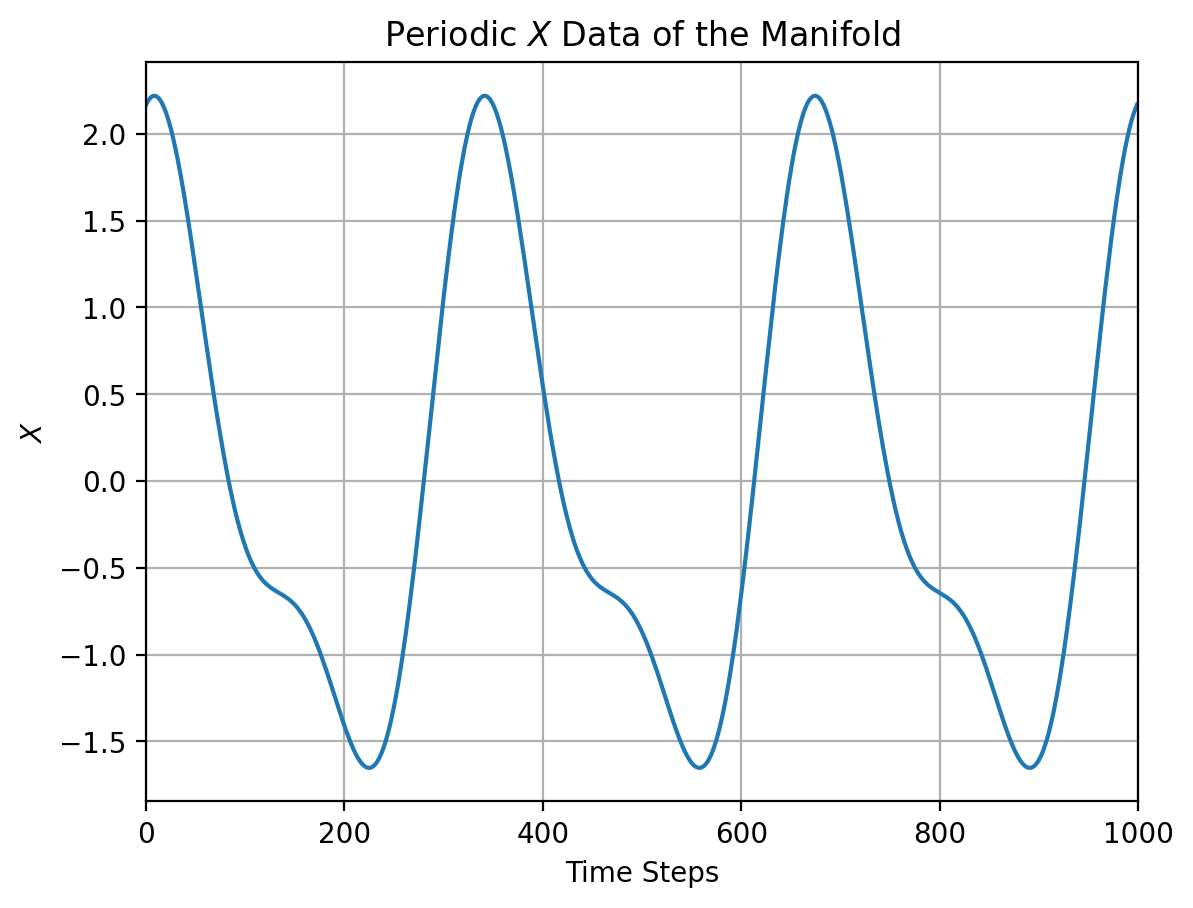

In [429]:
plt.plot(X)
plt.xlabel("Time Steps")
plt.ylabel(r"$X$")
plt.grid(True)
plt.xlim(0,1000)
plt.title(r"Periodic $X$ Data of the Manifold")

Text(0.5, 1.0, 'Periodic $X$ Data of the Manifold')

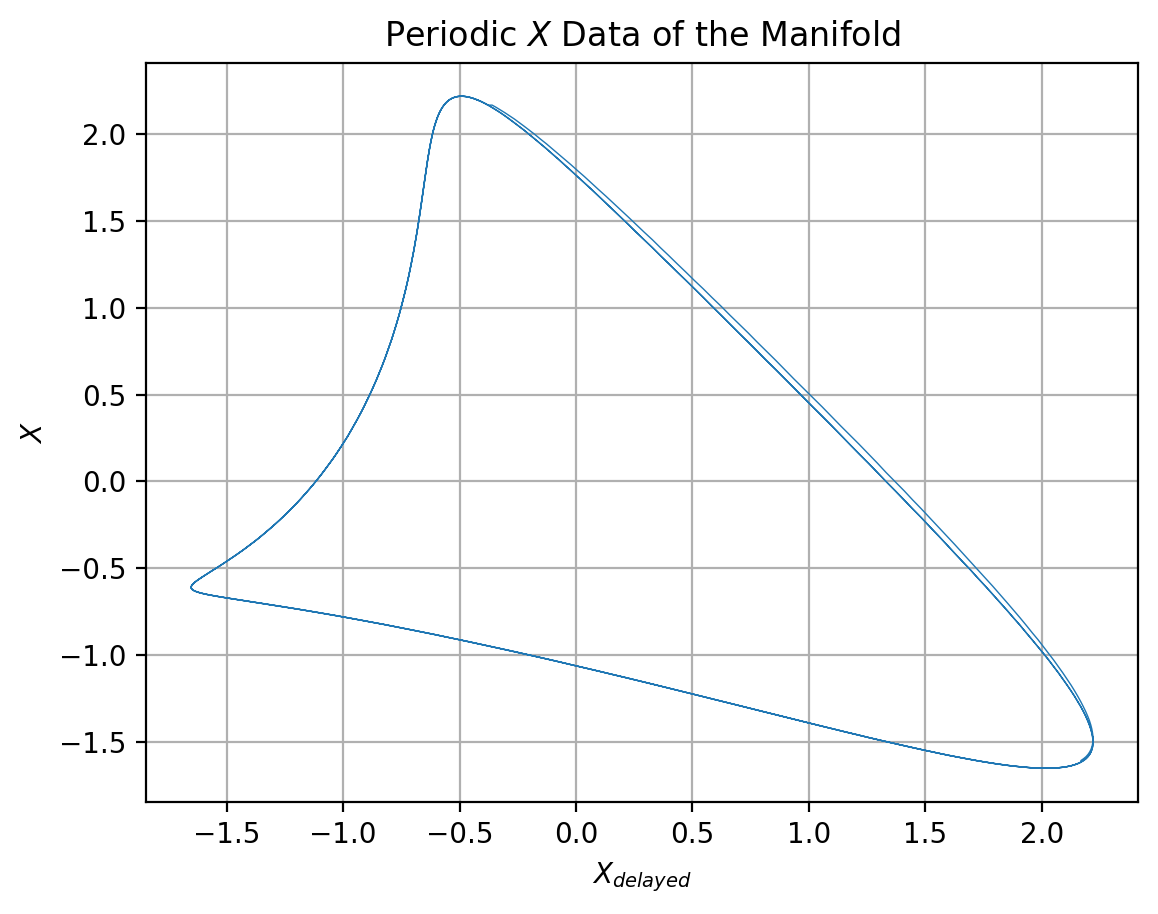

In [443]:
DELTA_N = 100
X_delayed = np.roll(X, DELTA_N)

plt.plot(X, X_delayed, linewidth=0.5)
plt.xlabel(r"$X_{delayed}$")
plt.ylabel(r"$X$")
plt.grid(True)
plt.title(r"Periodic $X$ Data of the Manifold")